# Fine-Tune Naive Bayes

## Load libraries

In [1]:
import pandas as pd
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

## Utils

In [2]:
def load_data(filename):
    """
    Input: string filename
    Output: a pandas dataframe for the whole dataset after droping missing values
    Support google colab or local environments
    """
    try:
        # local environment
        df = pd.read_csv(filename)
        df = df.dropna(subset=['sentence', 'label']) ## drop missing values
        return df
    except:
        # google colab environment
        from google.colab import drive
        drive.mount('/content/drive')
        
        df = pd.read_csv('/content/drive/MyDrive/' + filename)
        df = df.dropna(subset=['sentence', 'label']) ## drop missing values
        return df

In [3]:
def split_data(df):
    """
    Input: pandas dataframe
    Output: training dataframe (81%), validation dataframe (9%), test dataframe (10%)
    """
    df_train, df_val = train_test_split(df, stratify=df['label'],test_size=0.1, random_state=42)
    
    return df_train, df_val

In [4]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        Input: string text
        Output: string cleaned text
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

## Load data

In [5]:
FILENAME = 'final_dataset_formatted.csv'
TEST_FILENAME = 'final_dataset_formatted_test.csv'

# load data
df = load_data(FILENAME)
df_test = load_data(TEST_FILENAME)

# labels
labels = ['CC', 'NC', 'PW', 'HC', 'PL', 'CR', 'CG', 'BE', 'N']
num_labels = 9

# split data
df_train, df_val = split_data(df)

## Preprocess data

In [6]:
# clean text
df_train['sentence'] = df_train['sentence'].apply(clean_text)
df_val['sentence'] = df_val['sentence'].apply(clean_text)
df_test['sentence'] = df_test['sentence'].apply(clean_text)

In [7]:
# print processed sample data sentence
df_train.iloc[10, 0]

'total weight waste type disposal method'

In [8]:
# split text and labels
train_texts = df_train.iloc[:, 0]
train_labels = df_train.iloc[:, 1]
valid_texts = df_val.iloc[:, 0]
valid_labels = df_val.iloc[:, 1]
test_texts = df_test.iloc[:, 0]
test_labels = df_test.iloc[:, 1]

In [9]:
# get train, validation, and test dataset size
train_size = len(train_texts)
valid_size = len(valid_texts)
test_size = len(test_texts)

print(f'train size: {train_size}')
print(f'valid size: {valid_size}')
print(f'test size: {test_size}')

train size: 3645
valid size: 405
test size: 450


## Fine-Tune Model

In [10]:
alpha_list = [0, 0.05, 0.1, 0.15, 0.2, 1, 1.2, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 3, 4, 5] # 1

best_alpha = 0
best_acc = 0
max_f1 = 0

for alpha in alpha_list:
        
        # build model
        nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB(alpha=alpha)),
              ])

        # train model
        nb.fit(train_texts, train_labels)

        # generate prediction
        y_pred = nb.predict(valid_texts)

        # evaluate performance
        acc = accuracy_score(valid_labels, y_pred)
        f1 = f1_score(valid_labels, y_pred, average='macro')
        print(f'alpha: {alpha}:')
        print(f'accuracy: {acc:.4f}')
        print(f'macro_f1: {f1:.4f}')

        # save best model (highest macro_f1 score)
        if acc >= best_acc:
            best_alpha = alpha
            best_acc = acc
            max_f1 = f1

    #     print()

print(f'Best model: ')
print(f'alpha: {best_alpha}, acc: {best_acc}, macro_f1: {max_f1}')

C:\Users\cinni\anaconda3\envs\uropESG\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


alpha: 0:
accuracy: 0.6963
macro_f1: 0.6962
alpha: 0.05:
accuracy: 0.7975
macro_f1: 0.7987
alpha: 0.1:
accuracy: 0.8049
macro_f1: 0.8061
alpha: 0.15:
accuracy: 0.8099
macro_f1: 0.8102
alpha: 0.2:
accuracy: 0.8099
macro_f1: 0.8102
alpha: 1:
accuracy: 0.8123
macro_f1: 0.8112
alpha: 1.2:
accuracy: 0.8099
macro_f1: 0.8087
alpha: 1.5:
accuracy: 0.8123
macro_f1: 0.8110
alpha: 1.6:
accuracy: 0.8123
macro_f1: 0.8112
alpha: 1.7:
accuracy: 0.8123
macro_f1: 0.8117
alpha: 1.8:
accuracy: 0.8148
macro_f1: 0.8142
alpha: 1.9:
accuracy: 0.8148
macro_f1: 0.8142
alpha: 2:
accuracy: 0.8148
macro_f1: 0.8142
alpha: 3:
accuracy: 0.8025
macro_f1: 0.8013
alpha: 4:
accuracy: 0.7975
macro_f1: 0.7960
alpha: 5:
accuracy: 0.8000
macro_f1: 0.7986
Best model: 
alpha: 2, acc: 0.8148148148148148, macro_f1: 0.8142192193252957


## Final Naive Bayes Model

In [11]:
# build model
nb = Pipeline([('vect', CountVectorizer()),
       ('tfidf', TfidfTransformer()),
       ('clf', MultinomialNB(alpha=best_alpha)),
      ])

# train model
nb.fit(train_texts, train_labels)

# generate prediction
y_pred = nb.predict(valid_texts)
f1 = f1_score(valid_labels, y_pred, average='macro')

# evaluate model performance
print('accuracy %s' % accuracy_score(y_pred, valid_labels))
print(f'macro_f1 score: {f1}')
print(classification_report(valid_labels, y_pred,target_names=labels))

accuracy 0.8148148148148148
macro_f1 score: 0.8142192193252957
              precision    recall  f1-score   support

          CC       0.89      0.87      0.88        45
          NC       0.93      0.84      0.88        45
          PW       0.80      0.82      0.81        45
          HC       0.81      0.64      0.72        45
          PL       0.68      0.80      0.73        45
          CR       0.81      0.84      0.83        45
          CG       0.78      0.93      0.85        45
          BE       0.80      0.71      0.75        45
           N       0.89      0.87      0.88        45

    accuracy                           0.81       405
   macro avg       0.82      0.81      0.81       405
weighted avg       0.82      0.81      0.81       405



## Final Model Test Prediction

In [12]:
# generate prediction
y_pred = nb.predict(test_texts)
f1 = f1_score(test_labels, y_pred, average='macro')

# evaluate model performance
print('accuracy %s' % accuracy_score(y_pred, test_labels))
print(f'macro_f1 score: {f1}')
print(classification_report(test_labels, y_pred,target_names=labels))

accuracy 0.8288888888888889
macro_f1 score: 0.8298560451966204
              precision    recall  f1-score   support

          CC       0.83      0.88      0.85        50
          NC       0.88      0.84      0.86        50
          PW       0.82      0.84      0.83        50
          HC       0.88      0.72      0.79        50
          PL       0.66      0.82      0.73        50
          CR       0.87      0.78      0.82        50
          CG       0.92      0.90      0.91        50
          BE       0.81      0.84      0.82        50
           N       0.86      0.84      0.85        50

    accuracy                           0.83       450
   macro avg       0.84      0.83      0.83       450
weighted avg       0.84      0.83      0.83       450



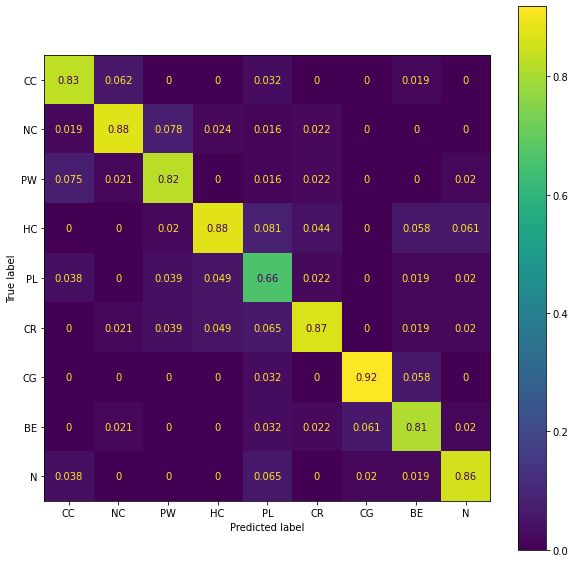

In [13]:
# plot confusion matrix
cm = confusion_matrix(test_labels, y_pred , normalize='pred')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)